In [1]:
import pandas as pd
import geopandas as gpd
# Import necessary geometric objects from shapely module
from shapely.geometry import Point, LineString, Polygon
import geopy
from geopy.geocoders import Nominatim
import skmob
import fiona

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_FITS.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_FITS.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF4.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF4.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF5.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF5.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load

### Geographic Partionining
* We have a few options in partionining mobile data spatially
    * __Option 1__: Call a free geocoding API (i.e. Nominatim) to get the relevant OpenStreetMap information. From here we can find the bounding box coordinates of a particular POI
    * __Option 2__: Partition by federal and/or state designations, i.e. census tracts, zip codes, etc.
    * __Option 3__: Type in a bounding box manually. For example, [geojson.io](https://geojson.io) could be a good option.
    * __Option 4__: Obtain a KMZ file from the [Damage Assessment Toolkit](https://apps.dat.noaa.gov/stormdamage/damageviewer/>).

#### Geocoding Example

In [127]:
locator = Nominatim(user_agent="Untitled-1")

In [128]:
location = locator.geocode("University of Washington, Seattle, WA, USA")
location.raw

{'place_id': 298767081,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'relation',
 'osm_id': 5268488,
 'boundingbox': ['47.647498', '47.6612001', '-122.3218398', '-122.2865938'],
 'lat': '47.6543466',
 'lon': '-122.30806059473039',
 'display_name': 'University of Washington, Montlake Boulevard Northeast, South Campus, University District, Seattle, King County, Washington, 98195, United States',
 'class': 'amenity',
 'type': 'university',
 'importance': 1.1184184230792567,
 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/education_university.p.20.png'}

In [6]:
#bbox = list()
#[bbox.append(float(i)) for i in location.raw['boundingbox']]
#bbox

In [7]:
#from shapely.geometry import box
#miny, maxy, minx, maxx = bbox
#poly = box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)
#poly

#### Census Tract Example

In [8]:
OK_url = "https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_40_tract_500k.zip"
OK_tracts = gpd.read_file(OK_url)
OK_tracts.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,NAMELSADCO,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,40,007,951600,1400000US40007951600,40007951600,9516,Census Tract 9516,OK,Beaver County,Oklahoma,CT,1971018179,6122262,"POLYGON ((-100.95421 36.71703, -100.95421 36.7..."
1,40,139,950800,1400000US40139950800,40139950800,9508,Census Tract 9508,OK,Texas County,Oklahoma,CT,5124635,0,"POLYGON ((-101.49220 36.68950, -101.48157 36.6..."
2,40,047,001100,1400000US40047001100,40047001100,11,Census Tract 11,OK,Garfield County,Oklahoma,CT,972877962,1905317,"POLYGON ((-98.10438 36.47031, -98.10437 36.477..."
3,40,131,050104,1400000US40131050104,40131050104,501.04,Census Tract 501.04,OK,Rogers County,Oklahoma,CT,1956422,0,"POLYGON ((-95.63264 36.31094, -95.62823 36.311..."
4,40,101,000200,1400000US40101000200,40101000200,2,Census Tract 2,OK,Muskogee County,Oklahoma,CT,8409929,35504,"POLYGON ((-95.41162 35.78401, -95.40494 35.784..."


In [9]:
IL_url = "https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_17_tract_500k.zip"
IL_tracts = gpd.read_file(IL_url)
IL_tracts.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,NAMELSADCO,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,17,143,000200,1400000US17143000200,17143000200,2,Census Tract 2,IL,Peoria County,Illinois,CT,971324,0,"POLYGON ((-89.64231 40.66903, -89.64230 40.670..."
1,17,143,003200,1400000US17143003200,17143003200,32,Census Tract 32,IL,Peoria County,Illinois,CT,3192142,0,"POLYGON ((-89.62153 40.77981, -89.62148 40.783..."
2,17,003,957900,1400000US17003957900,17003957900,9579,Census Tract 9579,IL,Alexander County,Illinois,CT,10197484,4353423,"POLYGON ((-89.19649 37.00498, -89.19298 37.006..."
3,17,073,030800,1400000US17073030800,17073030800,308,Census Tract 308,IL,Henry County,Illinois,CT,22273126,31720,"POLYGON ((-89.92486 41.24720, -89.92063 41.248..."
4,17,107,953100,1400000US17107953100,17107953100,9531,Census Tract 9531,IL,Logan County,Illinois,CT,13166640,375360,"POLYGON ((-89.41759 40.16712, -89.41683 40.172..."


#### Now let's read in our mobile data
* IL first

In [10]:
IL_data = pd.read_csv('IL_1000_April06-08.csv')
IL_gpd = gpd.GeoDataFrame(IL_data, crs='EPSG:4269', geometry=gpd.points_from_xy(IL_data['lon'], IL_data['lat']))
#aea_proj_str = '+proj=aea +lat_1=38.00 +lat_2=42.00 +lat_0=40.11 +lon_0=-88.228'
#IL_gpd = IL_gpd.to_crs(aea_proj_str)

In [11]:
# Exclude points outside of Illinois
IL_gpd_j = gpd.sjoin(IL_gpd, IL_tracts, how='inner', predicate='within')

In [12]:
print(IL_gpd.shape[0])
print(IL_gpd_j.shape[0])

235367
224500


In [183]:
tulsa_comp_1 = [[
              -95.48455104466989,
              35.63930557413467
            ],
            [
              -95.2884833730998,
              35.63885417218802
            ],
            [
              -95.28903880559699,
              35.700221424465425
            ],
            [
              -95.48455104466989,
              35.69886824399721
            ],
            [
              -95.47899671969661,
              35.67540946745373
            ],
            [
              -95.48455104466989,
              35.63930557413467
            ]
          ]

tulsa_comp_2 = [
            [
              -95.48692043438609,
              35.55248801759254
            ],
            [
              -95.49501552778821,
              35.52185712009455
            ],
            [
              -95.48489666103568,
              35.489237185219565
            ],
            [
              -95.27078144054869,
              35.489237185219565
            ],
            [
              -95.27078144054869,
              35.55051218364375
            ],
            [
              -95.48692043438609,
              35.55248801759254
            ]
          ]

from convenience import bounding_box

bounding_box(tulsa_comp_1)
#bounding_box(tulsa_comp_2)

[(-95.48455104466989, 35.63885417218802),
 (-95.2884833730998, 35.700221424465425)]

#### Let's look at Tulsa

In [4]:
OK_data = pd.read_csv('OK_damage_May14-16.csv')
OK_gpd_j = gpd.GeoDataFrame(OK_data, crs='EPSG:4269', geometry=gpd.points_from_xy(OK_data['lon'], OK_data['lat']))
#aea_proj_str = '+proj=aea +lat_1=38.00 +lat_2=42.00 +lat_0=40.11 +lon_0=-88.228'
#IL_gpd = IL_gpd.to_crs(aea_proj_str)

# Exclude points outside of Oklahoma
# OK_gpd_j = gpd.sjoin(OK_gpd, OK_tracts, how='inner', predicate='within')

# Create datetime column using timestamps
OK_gpd_j['datetime'] = pd.to_datetime(OK_gpd_j['timestamp'], unit='s')

# Create a date column
OK_gpd_j['date'] = OK_gpd_j['datetime'].dt.date

In [176]:
# Preprocess mobility data; separate by user_ID, filter out points with speed > 400 km/h, 
# and compress points within 200 m of each other in the same trajectory
tdf = skmob.TrajDataFrame(OK_gpd_j, latitude='lat', longitude='lon', datetime='datetime', user_id='uid')
f_tdf = skmob.preprocessing.filtering.filter(tdf, max_speed_kmh=400, include_loops=False)
fc_tdf = skmob.preprocessing.compression.compress(f_tdf, spatial_radius_km=0.2)

gdf_tulsa = gpd.GeoDataFrame(fc_tdf, crs='EPSG:4269', geometry=gpd.points_from_xy(fc_tdf['lng'], fc_tdf['lat']))

gdf_tulsa['datetime'] = pd.to_datetime(gdf_tulsa['datetime'], format='%Y-%m-%d %H:%M:%S')

In [179]:
gdf_tulsa = gpd.GeoDataFrame(fc_tdf, crs='EPSG:4269', geometry=gpd.points_from_xy(fc_tdf['lng'], fc_tdf['lat']))

# Drop datetime and date column
gdf_tulsa.drop(['datetime', 'date'], axis=1, inplace=True)
gdf_tulsa.explore()

In [167]:
gdf_tulsa['datetime'] = gdf_tulsa['datetime'].dt.strftime('%Y%m%d%H%M%S')

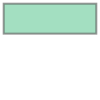

In [8]:
from shapely.geometry import box
# Define bounding box of damage site
minx, miny, maxx, maxy = [-95.526, 35.571, -95.254, 35.659]
poly = box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)
poly

In [9]:
# Retrieve all mobile data points within the bounding box
damage_area_pts = gdf_tulsa.cx[minx:maxx, miny:maxy]

In [10]:
damage_area_pts['datetime'] = pd.to_datetime(damage_area_pts['datetime'], format='%Y%m%d%H%M%S')
# Groupby 'uid' and sort by 'datetime'
damage_area_pts = damage_area_pts.groupby('uid').apply(lambda x: x.sort_values('datetime'))

# Make date column a string
damage_area_pts['date'] = damage_area_pts['datetime'].dt.date.astype(str)

# Separate by date
damage_area_pre = damage_area_pts[damage_area_pts['date'] == '2020-05-14']
damage_area_dur = damage_area_pts[damage_area_pts['date'] == '2020-05-15']
damage_area_post = damage_area_pts[damage_area_pts['date'] == '2020-05-16']

C:\Users\stlp\AppData\Local\Temp\ipykernel_3068\1601473356.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  damage_area_pts = damage_area_pts.groupby('uid').apply(lambda x: x.sort_values('datetime'))


In [87]:
damage_area_dur.iloc[-1]

Unnamed: 0                                                 25912
timestamp                                             1589557252
uid            12b4779932a6b1d2dcf7cc8940032d77b7bcae40f9ebc4...
dtype                                                          1
lat                                                    35.633588
lng                                                   -95.459912
acc                                                           12
tz                                                        -18000
class                                                      OTHER
transform                                                   KEEP
timestamp2                                            1589539252
datetime                                     2020-05-15 15:40:52
geometry                            POINT (-95.459912 35.633588)
index_right                                                 1137
STATEFP                                                       40
COUNTYFP                 

In [18]:
from skmob.measures.individual import jump_lengths, radius_of_gyration, home_location

damage_area_pre_tdf = skmob.TrajDataFrame(damage_area_pre, latitude='lat', longitude='lng', datetime='datetime', user_id='uid')
damage_area_dur_tdf = skmob.TrajDataFrame(damage_area_dur, latitude='lat', longitude='lng', datetime='datetime', user_id='uid')
damage_area_post_tdf = skmob.TrajDataFrame(damage_area_post, latitude='lat', longitude='lng', datetime='datetime', user_id='uid')

rg_df_pre = skmob.measures.individual.radius_of_gyration(damage_area_pre_tdf)
rg_df_dur = skmob.measures.individual.radius_of_gyration(damage_area_dur_tdf)
rg_df_post = skmob.measures.individual.radius_of_gyration(damage_area_post_tdf)

100%|██████████| 42/42 [00:00<00:00, 561.51it/s]


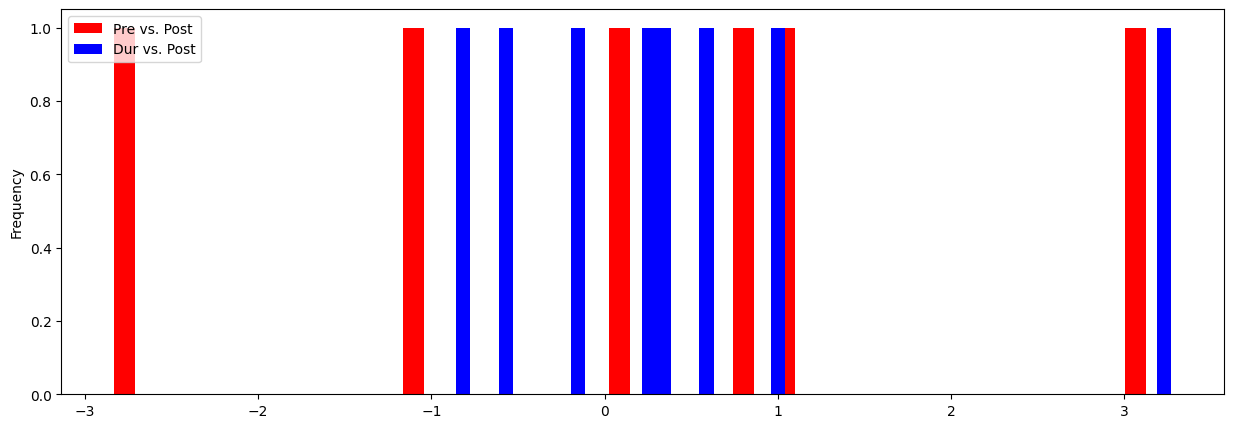

In [126]:
# Find difference in radius of gyration for the same uid (groupby uid)
rg_df_diff_pre_post = rg_df_pre.merge(rg_df_post, on='uid')
rg_df_diff_pre_dur = rg_df_pre.merge(rg_df_dur, on='uid')
rg_df_diff_dur_post = rg_df_dur.merge(rg_df_post, on='uid')

# Get the difference between x and y columns
rg_df_diff_pre_post['diff'] = rg_df_diff_pre_post['radius_of_gyration_x'] - rg_df_diff_pre_post['radius_of_gyration_y']
#rg_df_diff_pre_dur['diff'] = rg_df_diff_pre_dur['radius_of_gyration_x'] - rg_df_diff_pre_dur['radius_of_gyration_y']
rg_df_diff_dur_post['diff'] = rg_df_diff_dur_post['radius_of_gyration_x'] - rg_df_diff_dur_post['radius_of_gyration_y']

# Plot the difference in radius of gyration for the same uid (groupby uid)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
rg_df_diff_pre_post['diff'].plot.(ax=ax, bins=50, label='Pre vs. Post', color='red')
#rg_df_diff_pre_dur['diff'].plot.hist(ax=ax, bins=50, label='Pre vs. Dur', color='green')
rg_df_diff_dur_post['diff'].plot.hist(ax=ax, bins=50, label='Dur vs. Post', color='blue')

# Plot legend
ax.legend()

In [122]:
rg_df_diff_dur_post['diff']

0    0.596009
1   -0.555450
2   -0.190290
3   -0.857151
4    3.268419
5    1.034823
6    0.293495
7    0.364728
Name: diff, dtype: float64

In [133]:
vis_per_h_post

,n_visits,post_dur_diff,post_pre_diff,sum_diff
datetime,,,,
2020-05-16 05:00:00,9,9,6,3
2020-05-16 06:00:00,2,1,2,3
2020-05-16 07:00:00,1,0,-1,-2
2020-05-16 08:00:00,5,4,5,6
2020-05-16 09:00:00,1,1,-9,-19
2020-05-16 10:00:00,0,0,-5,-10
2020-05-16 11:00:00,4,4,-1,-6
2020-05-16 12:00:00,1,-8,-32,-56
2020-05-16 13:00:00,14,-2,-19,-36


In [134]:
vis_per_h_dur

,n_visits,dur_pre_diff
datetime,,
2020-05-15 05:00:00,0,-3
2020-05-15 06:00:00,1,1
2020-05-15 07:00:00,1,-1
2020-05-15 08:00:00,1,1
2020-05-15 09:00:00,0,-10
2020-05-15 10:00:00,0,-5
2020-05-15 11:00:00,0,-5
2020-05-15 12:00:00,9,-24
2020-05-15 13:00:00,16,-17


### Repeat analysis
* Reprocess data to include a whole month prior
    * Will use this to get standard deviation in RoG, Visits per Hour
* Get bounding boxes nearby the area of interest to baseline these statistics
    * Three other areas with roads/settlements nearby

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, '5'),
  Text(1, 0, '6'),
  Text(2, 0, '7'),
  Text(3, 0, '8'),
  Text(4, 0, '9'),
  Text(5, 0, '10'),
  Text(6, 0, '11'),
  Text(7, 0, '12'),
  Text(8, 0, '13'),
  Text(9, 0, '14'),
  Text(10, 0, '15'),
  Text(11, 0, '16'),
  Text(12, 0, '17'),
  Text(13, 0, '18'),
  Text(14, 0, '19'),
  Text(15, 0, '20'),
  Text(16, 0, '21'),
  Text(17, 0, '22'),
  Text(18, 0, '23')])

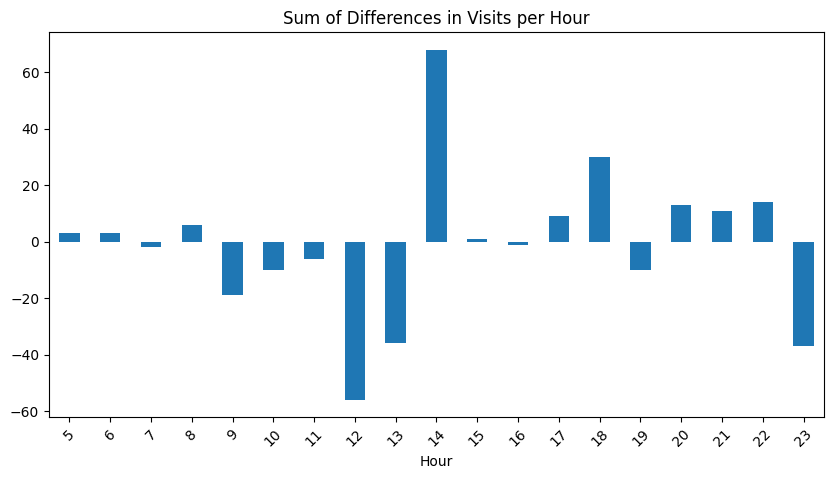

In [115]:
import skmob.measures.collective
import matplotlib.pyplot as plt
import numpy as np

vis_per_h_pre = skmob.measures.collective.visits_per_time_unit(damage_area_pre_tdf, time_unit='1h')
vis_per_h_dur = skmob.measures.collective.visits_per_time_unit(damage_area_dur_tdf, time_unit='1h')
vis_per_h_post = skmob.measures.collective.visits_per_time_unit(damage_area_post_tdf, time_unit='1h')

# Get only 5am till midnight for during and post
vis_per_h_dur = vis_per_h_dur.iloc[5:24]
vis_per_h_post = vis_per_h_post.iloc[5:24]

# Find differences among the three time periods
vis_per_h_post['post_dur_diff'] = vis_per_h_post.values - vis_per_h_dur.values
vis_per_h_post['post_pre_diff'] = vis_per_h_post.values[:, 0].reshape(-1,1) - vis_per_h_pre.values
vis_per_h_dur['dur_pre_diff'] = vis_per_h_dur.values - vis_per_h_pre.values

# Find sum of differences
vis_per_h_post['sum_diff'] = vis_per_h_post.values[:, 2].reshape(-1,1) + vis_per_h_dur.values[:,1].reshape(-1,1)

# Plot sum of differences
vis_per_h_post['sum_diff'].plot(kind='bar', figsize=(10,5 ), title='Sum of Differences in Visits per Hour')

# Make x axis hours from 5am till midnight
plt.xticks(np.arange(0, 19, step=1), np.arange(5, 24, step=1))
plt.xlabel('Hour')
# Rotate x axis labels
plt.xticks(rotation=45)

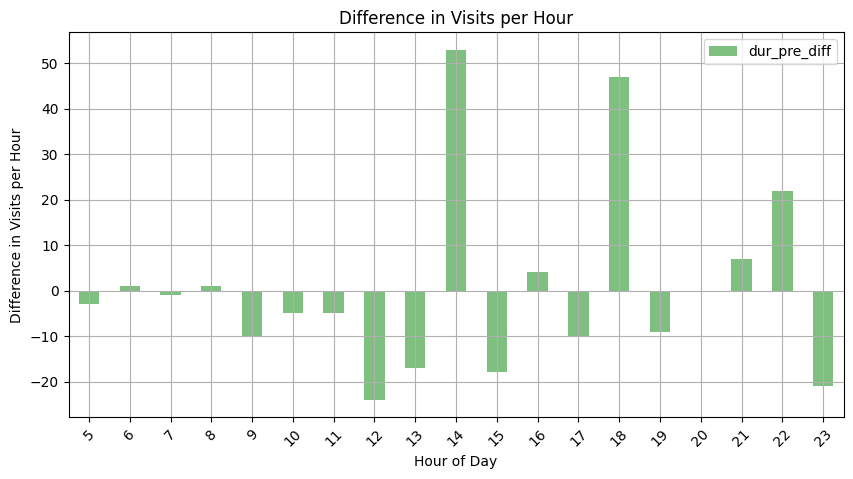

In [136]:
# Plot the difference on the same graph, bars on the side by side
f, ax = plt.subplots(1, 1, figsize=(20,5))
#vis_per_h_post.plot.bar(y='post_dur_diff', figsize=(10,5), ax=ax, color='red', alpha=0.5) 
vis_per_h_dur.plot.bar(y='dur_pre_diff', figsize=(10,5), ax=ax, color='green', alpha=0.5)
#vis_per_h_post.plot.bar(y='post_pre_diff', figsize=(10,5), ax=ax, color='blue', alpha=0.5)

# X-ticks should only be hours of the day, starting from 5am to midnight
plt.xticks(np.arange(0, 19, 1), np.arange(5, 24, 1))

# Rotate x-ticks
plt.xticks(rotation=45)
# Turn on grid
plt.grid()
# Make the plot look nicer
plt.title('Difference in Visits per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Difference in Visits per Hour')
plt.show()

In [96]:
vis_per_h_post['hour'] = np.arange(5, 24, 1).astype(int)
# do for all
vis_per_h_dur['hour'] = np.arange(5, 24, 1).astype(int)
vis_per_h_pre['hour'] = np.arange(5, 24, 1).astype(int)

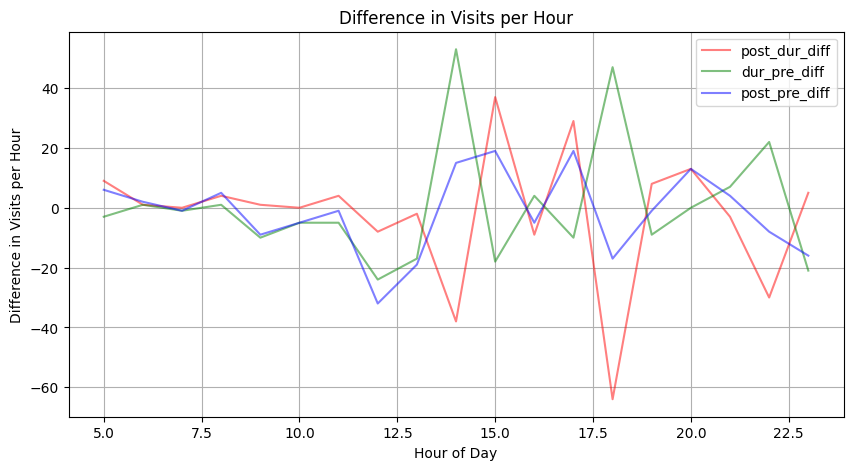

In [102]:
f, ax = plt.subplots(1, 1, figsize=(20,5))
# Scatterplot of the difference in visits per hour between all three days, three different colors
vis_per_h_post.plot.line(x='hour', y='post_dur_diff', figsize=(10,5), color='red', alpha=0.5, ax=ax, label='post_dur_diff')
vis_per_h_dur.plot.line(x='hour', y='dur_pre_diff', figsize=(10,5), color='green', alpha=0.5, ax=ax, label='dur_pre_diff')
vis_per_h_post.plot.line(x='hour', y='post_pre_diff', figsize=(10,5), color='blue', alpha=0.5,ax=ax, label='post_pre_diff')

# Turn on legend
plt.legend()

# Turn on grid
plt.grid()
# Make the plot look nicer
plt.title('Difference in Visits per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Difference in Visits per Hour')
plt.show()